# Extra examples

Yeah, I can't think of any names.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.datasets import make_classification
from itertools import cycle
from samplics.categorical import CrossTabulation
from typing import Literal, Optional

gss_saf = pd.read_csv("data/safiya_clean.csv")
gss_theo = pd.read_csv("data/theo_clean.csv")


def recode_age(age: int | Literal[np.nan, pd.NA]):
    """Destroy age by recoding it into a category.

    Parameters
    ----------
    age: int | Literal[np.nan, pd.NA]
        `age` feature from GSS.

    Returns
    -------
    str
        Lossy, categorized age as a string.
    """
    if age in range(18, 30):
        return "18-29"
    elif age in range(30, 40):
        return "30-39"
    elif age in range(40, 50):
        return "40-49"
    elif age in range(50, 60):
        return "50-59"
    elif age in range(60, 70):
        return "60-69"
    elif age > 69:
        return "70+"
    else:
        return pd.NA


def plot_aesthetics(fig: plt.Figure, ax: plt.Axes, title: Optional[str] = None) -> None:
    """Clean up plot aesthetics.

    Removes unimportant link from an Axes.

    Parameters
    ----------
    fig: plt.Figure
        Figure upon which Axes is plotted.
    ax: plt.Axes
        Plot.

    Returns
    -------
    None
    """
    # Title
    ax.set_title(title, fontsize=16, fontweight="bold")

    # Remove unimportant ink
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # Remove legend title
    legend: plt.legend.Legend = ax.get_legend()
    legend.set_title(None)
    legend.draw_frame(False)

    # Remove spines and set the layout to tight
    sns.despine(fig, ax)
    fig.set_tight_layout(True)


def weighted_kde(
    data: pd.DataFrame,
    x: str,
    y: Optional[str] = None,
    hue: Optional[str] = None,
    weights: Optional[str] = None,
    normalize: bool = False,
    palette: Optional[list[str] | dict[str, str]] = None,
    edgecolor: Optional[str | list[str]] = "black",
    figsize: Optional[tuple[int, int]] = (10, 8),
    title: Optional[str] = None,
) -> (plt.Figure, plt.Axes):
    """Meow."""
    fig: plt.Figure
    ax: plt.Axes

    fig, ax = plt.subplots(figsize=figsize)
    sns.kdeplot(
        data=data,
        x=x,
        hue=hue,
        weights=weights,
        cut=0,
        fill=True,
        common_norm=normalize,
        palette=palette,
        ax=ax,
        edgecolor=edgecolor,
    )
    plot_aesthetics(fig, ax, title)

    return fig, ax


def crosstab_barplots(
    data: pd.DataFrame,
    x: str,
    y: str,
    hue: Optional[str] = None,
    weights: Optional[str] = None,
    stratum: Optional[str] = None,
    psu: Optional[str] = None,
    percents: Optional[bool] = True,
    palette: Optional[list[str] | dict[str, str]] = None,
    figsize: Optional[tuple[int, int]] = (10, 8),
    title: Optional[str] = None,
    sort: Optional[bool] = False,
    normalize: Optional[str] = None,
) -> (plt.Figure, plt.Axes):
    """Meow."""

    # Calculate cross tabulation
    tab_ct: CrossTabulation = CrossTabulation("proportion")
    tab_ct.tabulate(
        vars=data[[x, y]],
        samp_weight=data[weights] if weights else None,
        stratum=data[stratum] if stratum else None,
        psu=data[psu] if psu else None,
        remove_nan=True,
    )

    table: pd.DataFrame = tab_ct.to_dataframe()

    # Normalize group to 1.0 if asked
    if normalize:
        table = table.assign(
            proportion=table.groupby(normalize)["proportion"].transform(
                lambda prop: prop / prop.sum()
            )
        )

    # Convert to percents if asked
    if percents:
        table["proportion"] = table["proportion"] * 100

    # Sort proportions if asked
    if sort:
        table = table.sort_values("proportion")

    # Plot bar
    fig: plt.Figure
    ax: plt.Axes
    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(x=x, y="proportion", hue=hue, data=table, palette=palette, ax=ax)
    plot_aesthetics(fig, ax, title)

    return fig, ax


gss_theo["age_cat"] = gss_theo["age"].map(recode_age)


## Plot examples (Theo)

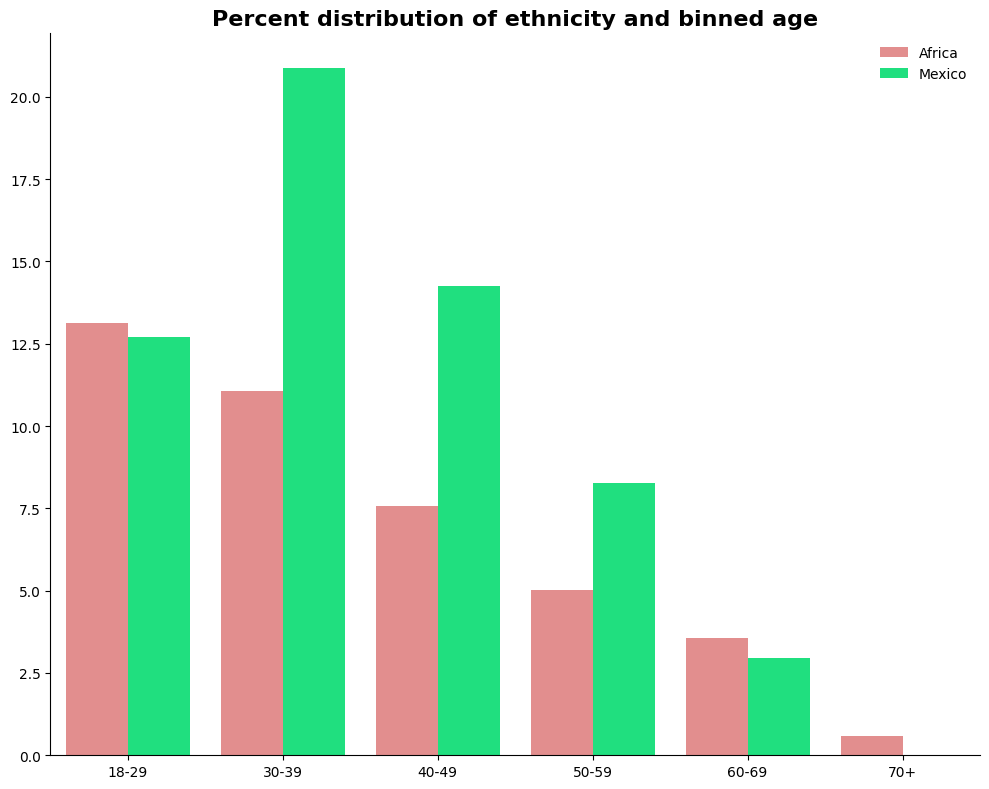

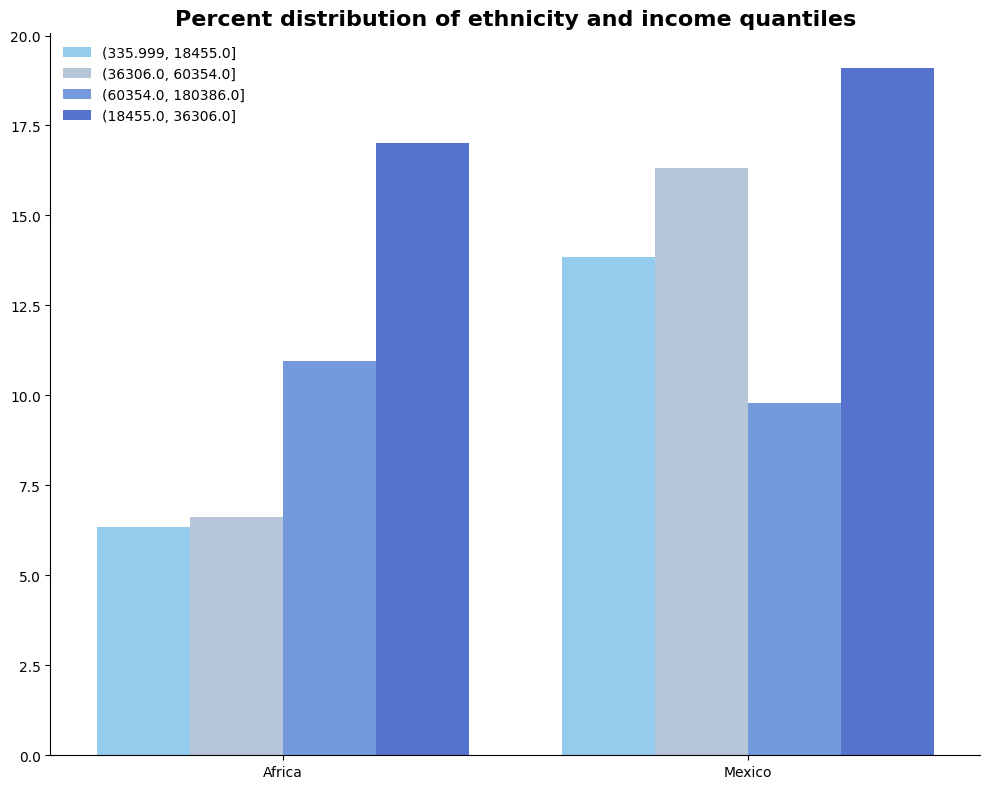

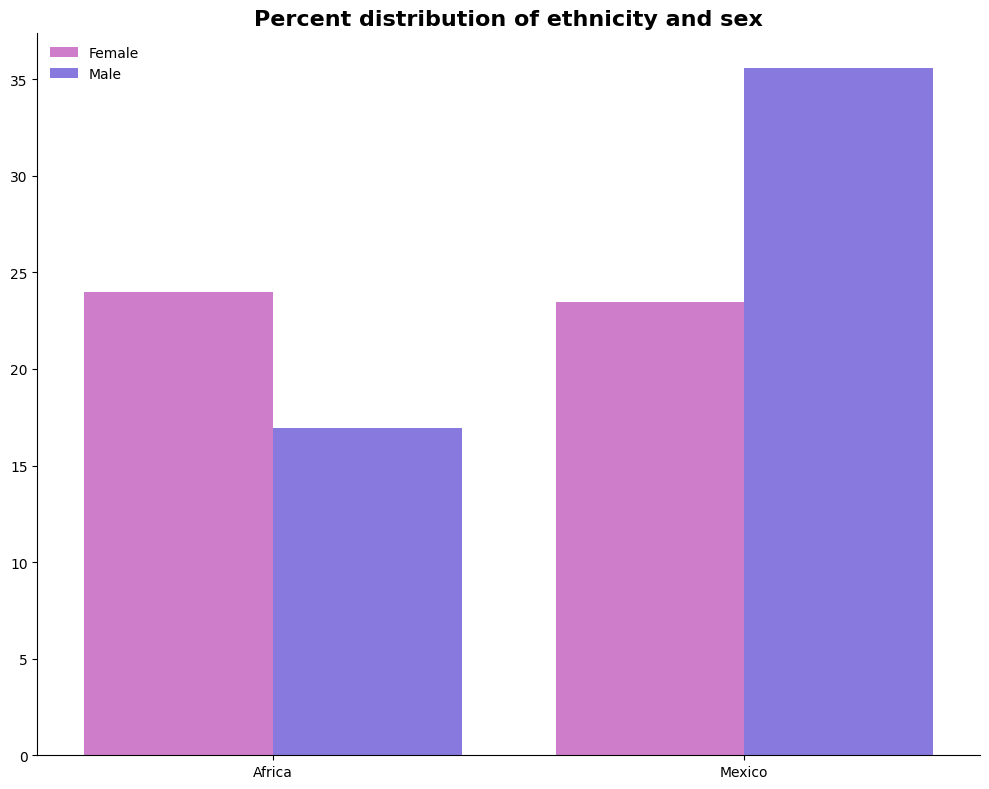

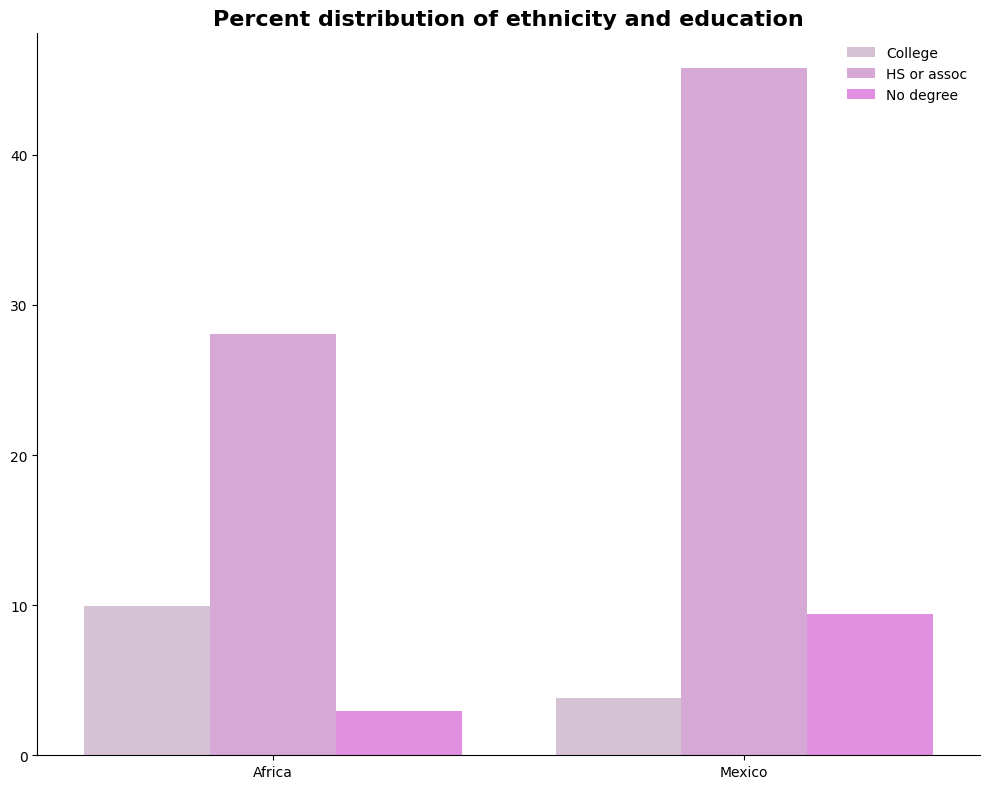

In [2]:
gss_theo = gss_theo.dropna()

ethn_age_fig, ethn_age_ax = crosstab_barplots(
    gss_theo,
    x="age_cat",
    y="ethnic",
    hue="ethnic",
    weights="wtsscomp",
    psu="vpsu",
    palette=["lightcoral", "springgreen"],
    title="Percent distribution of ethnicity and binned age",
)

ethn_inc_fig, ethn_inc_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="coninc_quantiles",
    hue="coninc_quantiles",
    weights="wtsscomp",
    psu="vpsu",
    palette=["lightskyblue", "lightsteelblue", "cornflowerblue", "royalblue"],
    title="Percent distribution of ethnicity and income quantiles",
    sort=True,
)

ethn_sex_fig, ethn_sex_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="sex",
    hue="sex",
    weights="wtsscomp",
    psu="vpsu",
    palette=["orchid", "mediumslateblue"],
    title="Percent distribution of ethnicity and sex",
)

ethn_degree_fig, ethn_degree_ax = crosstab_barplots(
    gss_theo,
    x="ethnic",
    y="degree",
    hue="degree",
    weights="wtsscomp",
    psu="vpsu",
    palette=["thistle", "plum", "violet"],
    title="Percent distribution of ethnicity and education",
)


## Plot examples (Safiya)

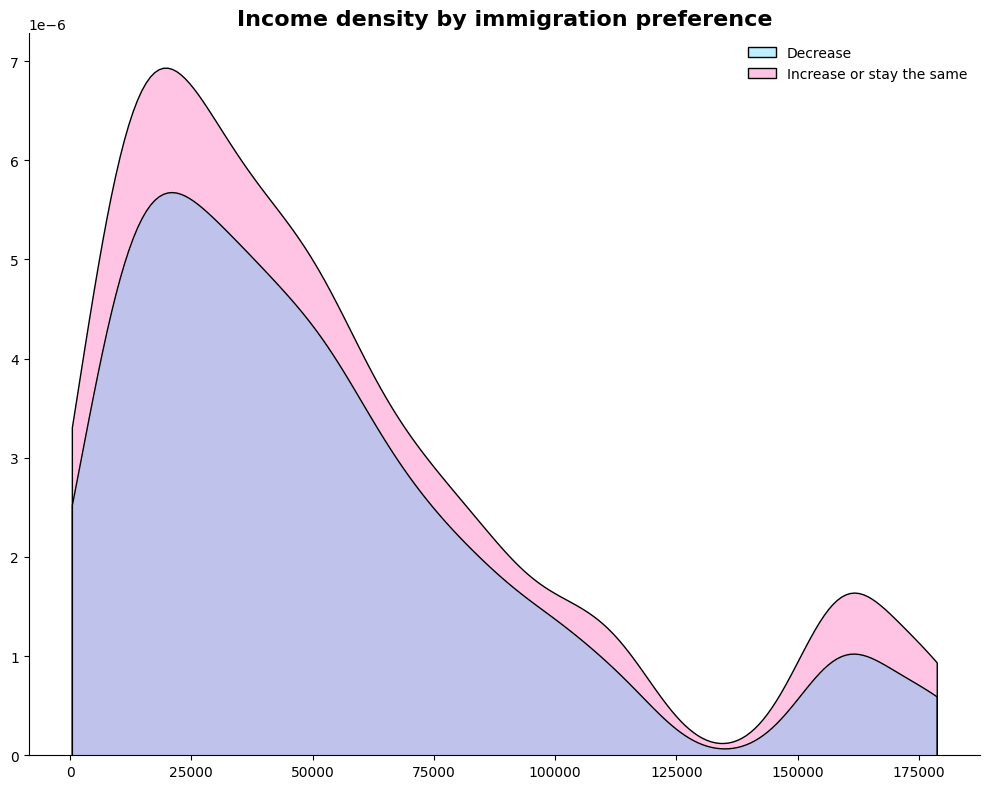

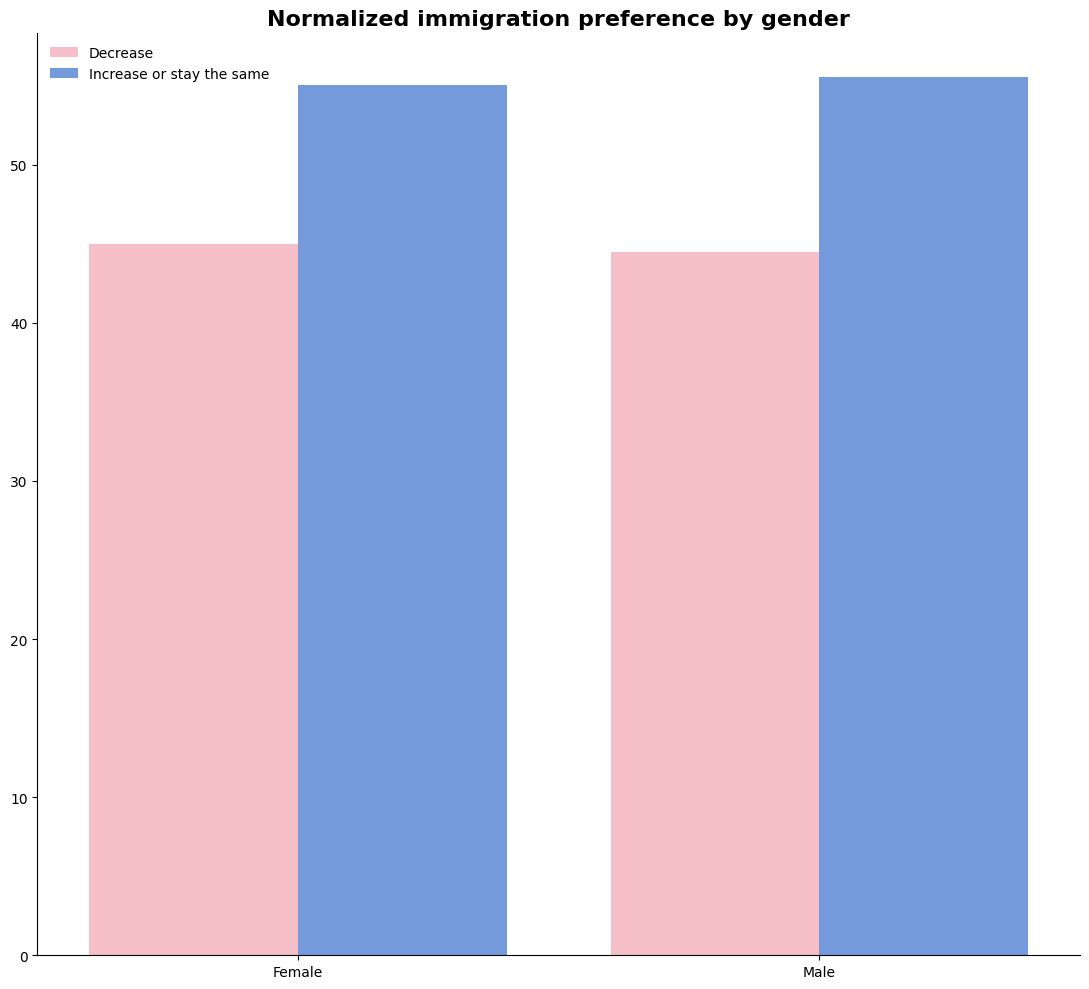

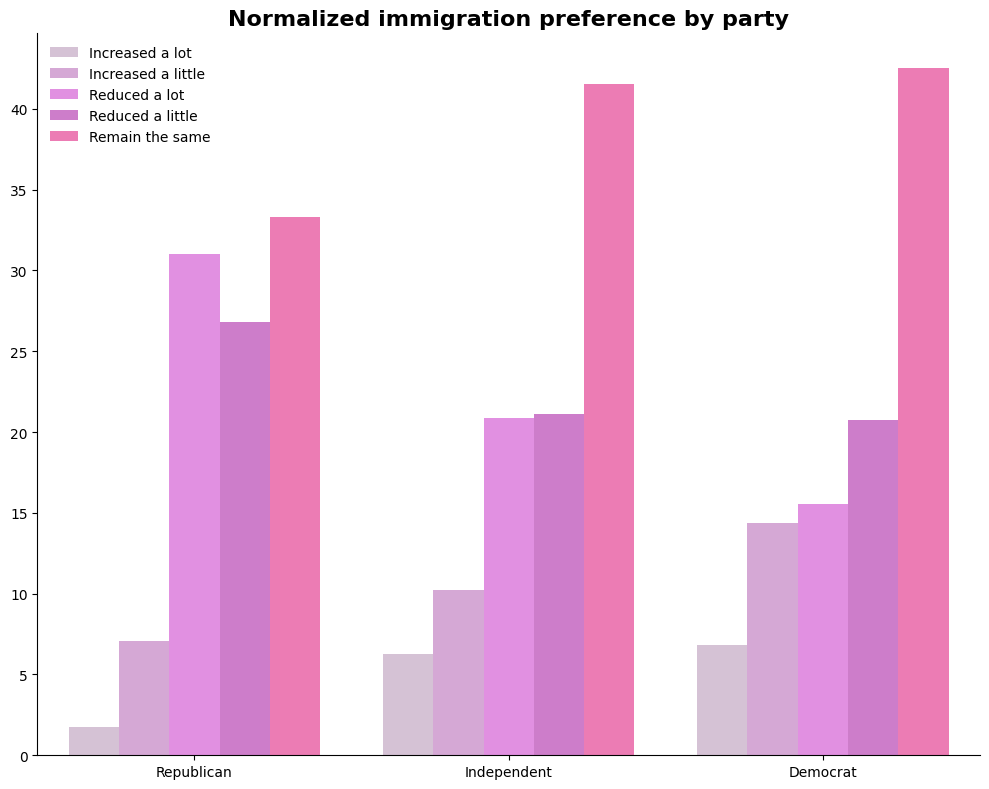

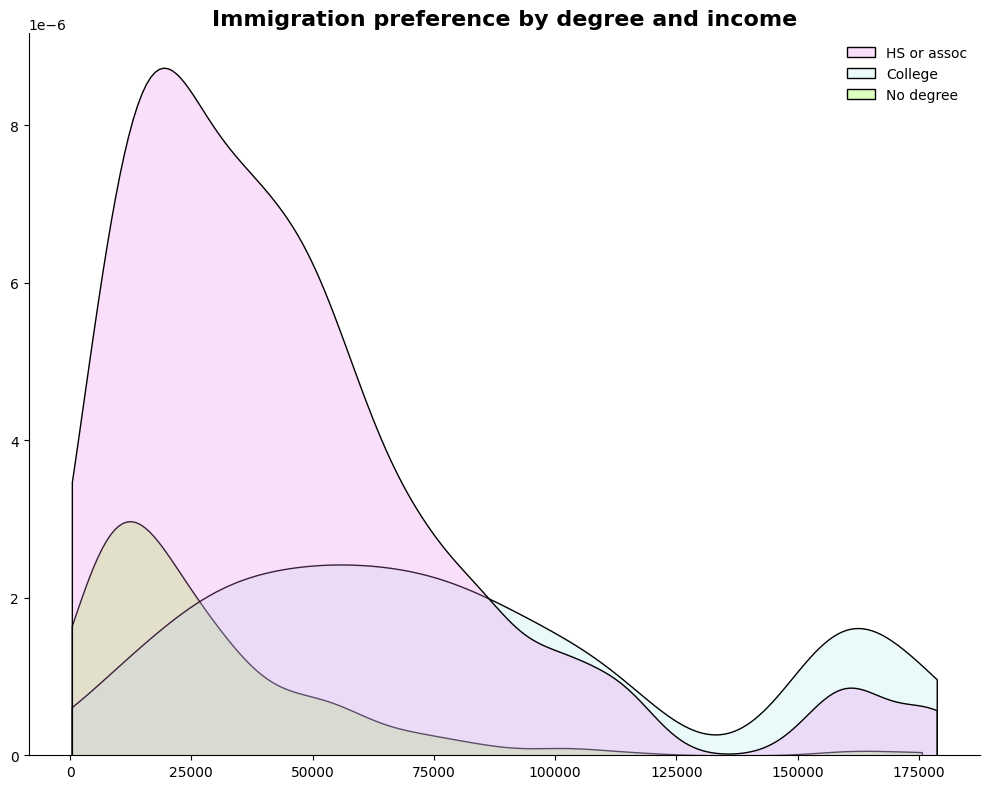

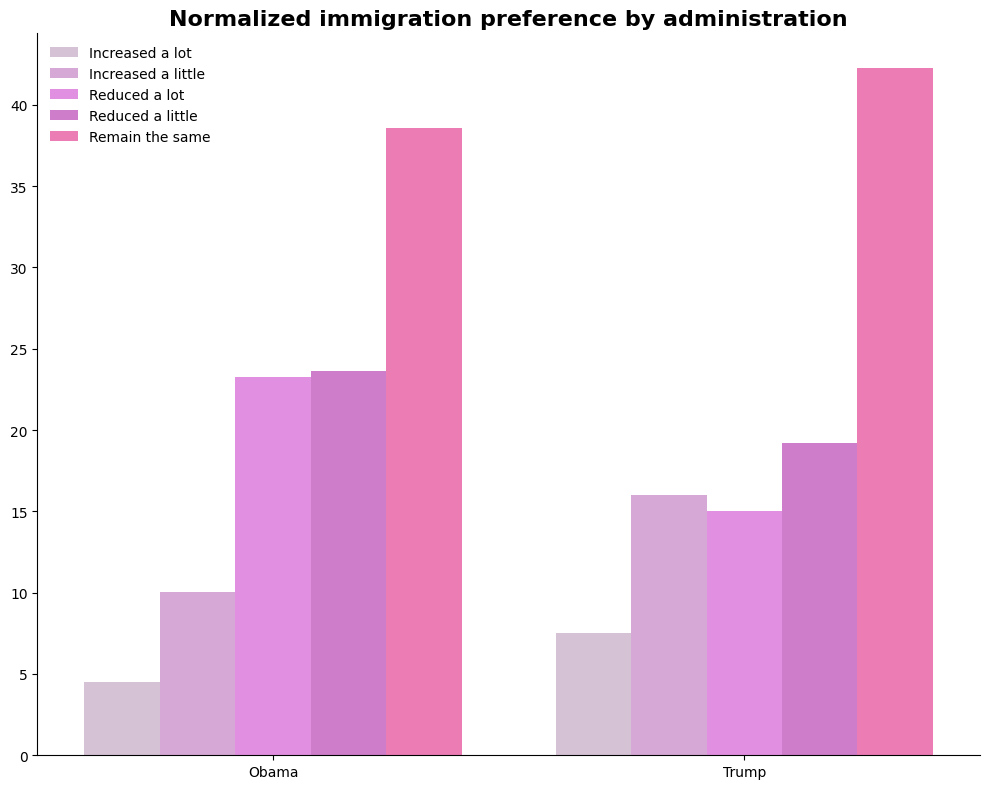

In [3]:
gss_saf = gss_saf.dropna()

coninc_imm_fig, coninc_imm_ax = weighted_kde(
    gss_saf,
    x="coninc",
    hue="decrease_imm",
    weights="wtsscomp",
    normalize=True,
    palette=["deepskyblue", "deeppink"],
    title="Income density by immigration preference",
)

imm_gend_fig, imm_gend_ax = crosstab_barplots(
    gss_saf,
    x="sex",
    y="decrease_imm",
    hue="decrease_imm",
    weights="wtsscomp",
    psu="vpsu",
    figsize=(11, 10),
    palette=["lightpink", "cornflowerblue"],
    title="Normalized immigration preference by gender",
    normalize="sex",
)

party_letin_fig, party_letin_ax = crosstab_barplots(
    gss_saf,
    x="partyid",
    y="letin1a",
    hue="letin1a",
    weights="wtsscomp",
    psu="vpsu",
    sort=True,
    palette=["thistle", "plum", "violet", "orchid", "hotpink"],
    title="Normalized immigration preference by party",
    normalize="partyid",
)

ses_fig, ses_ax = weighted_kde(
    gss_saf,
    x="coninc",
    y="decrease_imm",
    hue="degree",
    weights="wtsscomp",
    normalize=True,
    palette=["violet", "paleturquoise", "chartreuse"],
    # edgecolor=["indigo", "darkturquoise", "forestgreen"],
    title="Immigration preference by degree and income",
)

prez_fig, prez_ax = crosstab_barplots(
    gss_saf,
    x="president",
    y="letin1a",
    hue="letin1a",
    weights="wtsscomp",
    psu="vpsu",
    sort=True,
    palette=["thistle", "plum", "violet", "orchid", "hotpink"],
    title="Normalized immigration preference by administration",
    normalize="president",
)


## Chi square explanation

Let's take a look at some fake data.

In [4]:
party = ["Democrat", "Republican"]
pastry = ["Cupcake", "Pie"]

party_array = np.repeat(party, [200, 200])
pastry_array = np.fromiter(cycle(pastry), np.dtype(("U", 7)), count=400)
great_debate = pd.DataFrame(
    {"party": party_array, "pastry": pastry_array}, dtype="category"
)

great_debate.head()


,party,pastry
0,Democrat,Cupcake
1,Democrat,Pie
2,Democrat,Cupcake
3,Democrat,Pie
4,Democrat,Cupcake


Traditional statistics is centered around inference. Researchers form a hypothesis which they test against a reasonable default. The reasonable default is called the **null hypothesis** or `H0`. `H0` is usually that there is no observable difference beyond random chance. This is also why traditional stats reports p-values. P-values are the probability that an observed difference is due to random chance.

For example, let's say we run a t-test between the mean ages of people who prefer strawberry ice cream and those who prefer chocolate.

`H0`: The difference in means between the ages of strawberry ice cream fans and chocolate ice cream fans is 0.

`H1`: Strawberry fans tend to be younger than choco fans.

You calculate the difference in means between your two groups which turns out to be `7`. Great! Seven seems like a significant difference, right? You calculate your t-statistic and then the associated p-value: .6 with your alpha set at .05.

You accept the null hypothesis that there isn't a statistically significant difference between the ages of strawberry and chocolate fans. In other words, if you were to resample your data set, the difference in means would be within the margin of error. You can't claim that there is a likely difference between the means because there is a 60% chance that it is just due to randomness.

Chi square is another traditional stats test that accounts for the probability that categorical variables are randomly dispersed. A random trait, such as whether a person prefers cupcakes or pies, should be somewhat evenly distributed across a population. For example, you wouldn't expect a person's gender or political party to matter as to whether they prefer either pastry. If more people overall prefer pie, you wouldn't expect that difference to be split by party.

Take a look at the cross tabulation of the data I made above.

In [5]:
tab_great_debate = pd.crosstab(great_debate["pastry"], great_debate["party"])
tab_great_debate


party,Democrat,Republican
pastry,,
Cupcake,100,100
Pie,100,100


My data set is totally balanced. Neither party's members seem to prefer a specific pastry. The expected p value is near 1.0 since the variable is completely random.

In [6]:
chi2_contingency(tab_great_debate)


Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[100., 100.],
       [100., 100.]]))

And it is! What about if 30 of the observations were skewed in some way? If Democrats are slightly skewed to Cupcake and Republicans are slightly skewed to Pie, would that make a difference?

In [7]:
great_debate.loc[185:199, "pastry"] = "Cupcake"
great_debate.loc[285:299, "pastry"] = "Pie"
tab_redux = pd.crosstab(great_debate["pastry"], great_debate["party"])
tab_redux


party,Democrat,Republican
pastry,,
Cupcake,108,93
Pie,92,107


And now let's look at the chi square statistic.

In [8]:
chi2_contingency(tab_redux)


Chi2ContingencyResult(statistic=1.960049001225031, pvalue=0.16150807797217792, dof=1, expected_freq=array([[100.5, 100.5],
       [ 99.5,  99.5]]))

The p value is .16 which is above my alpha of 0.05. I can't reject the null hypothesis of no difference because, in terms of probability, a sample like the above is within the margins of error. Okay, now let's resample the whole data set.

In [9]:
rng = np.random.default_rng()

great_debate = great_debate.assign(
    **{
        column: rng.choice(great_debate[column].unique(), great_debate.shape[0], p=p)
        for (column, p) in zip(great_debate.columns, [None, [0.4, 0.6]])
    }
)

tab_new_sample = pd.crosstab(great_debate["party"], great_debate["pastry"])
tab_new_sample


pastry,Cupcake,Pie
party,,
Democrat,68,127
Republican,86,119


I weighted the sample so that `Pie` is more likely to be selected as you can see from above. What about our chi square?

In [10]:
print(chi2_contingency(tab_new_sample))

party_counts = great_debate["party"].value_counts()
party_counts


Chi2ContingencyResult(statistic=1.8269522136268137, pvalue=0.17648795938061873, dof=1, expected_freq=array([[ 75.075, 119.925],
       [ 78.925, 126.075]]))


Republican    205
Democrat      195
Name: party, dtype: int64

This is still within the realm of no probable difference. I guess we should skew it even further!

In [11]:
great_debate.loc[great_debate["party"] == "Democrat", "pastry"] = rng.choice(
    pastry, party_counts["Democrat"], p=[0.75, 0.25]
)
great_debate.loc[great_debate["party"] == "Republican", "pastry"] = rng.choice(
    pastry, party_counts["Republican"], p=[0.25, 0.75]
)

skewed_debate = pd.crosstab(great_debate["party"], great_debate["pastry"])
print(chi2_contingency(skewed_debate))
skewed_debate


Chi2ContingencyResult(statistic=75.88504786935407, pvalue=3.006681619675953e-18, dof=1, expected_freq=array([[ 98.9625,  96.0375],
       [104.0375, 100.9625]]))


pastry,Cupcake,Pie
party,,
Democrat,143,52
Republican,60,145


## Logistic regression explanation

In [12]:
X_cls, y_cls = make_classification()


## Confusion matrix